In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/My Drive/BitsXlaMarató/specgrams/TRAIN'
test_dir = '/content/drive/My Drive/BitsXlaMarató/specgrams/TEST'
transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(217),
                                            torchvision.transforms.Resize(112),
                                            torchvision.transforms.Grayscale(),
                                            torchvision.transforms.ToTensor()])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
## test git

In [16]:
for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: torch.Size([64, 1, 217, 217])
labels batch shape: torch.Size([64])


In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()
        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.float().to(device)
            target = target.unsqueeze(-1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            pred = output.round()  # get the prediction
            acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
            train_accuracy.update(acc, n=len(target))
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()
        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.float().to(device)
                target = target.unsqueeze(-1)
                output = model(data)
                loss = loss_fn(output, target)
                val_loss.update(loss.item(), n=len(target))
                pred = output.round()  # get the prediction
                acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
                val_accuracy.update(acc, n=len(target))
                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)
        
    return train_accuracies, train_losses, val_accuracies, val_losses

# Building Network

In [23]:
model = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256*5*5, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=6400, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=1, bias=True)
  (16): Sigmoid()
)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we choose BCELoss because we have two classes
loss_fn = nn.BCELoss()

In [27]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

Streaming output truncated to the last 5000 lines.


[TRAIN] Epoch 36/60:  36%|███▋      | 4/11 [00:18<00:31,  4.51s/ batches, accuracy=0.992, loss=0.0142]



[TRAIN] Epoch 36/60:  36%|███▋      | 4/11 [00:18<00:31,  4.51s/ batches, accuracy=0.992, loss=0.0142]



[TRAIN] Epoch 36/60:  36%|███▋      | 4/11 [00:22<00:31,  4.51s/ batches, accuracy=0.994, loss=0.013] 



[TRAIN] Epoch 36/60:  45%|████▌     | 5/11 [00:22<00:27,  4.50s/ batches, accuracy=0.994, loss=0.013]



[TRAIN] Epoch 36/60:  45%|████▌     | 5/11 [00:22<00:27,  4.50s/ batches, accuracy=0.994, loss=0.013]



[TRAIN] Epoch 36/60:  45%|████▌     | 5/11 [00:27<00:27,  4.50s/ batches, accuracy=0.995, loss=0.0125]



[TRAIN] Epoch 36/60:  55%|█████▍    | 6/11 [00:27<00:22,  4.50s/ batches, accuracy=0.995, loss=0.0125]



[TRAIN] Epoch 36/60:  55%|█████▍    | 6/11 [00:27<00:22,  4.50s/ batches, accuracy=0.995, loss=0.0125]



[TRAIN] Epoch 36/60:  55%|█████▍    | 6/11 [00:31<00:22,  4.50s/ batches, accuracy=0.996, loss=0.013]

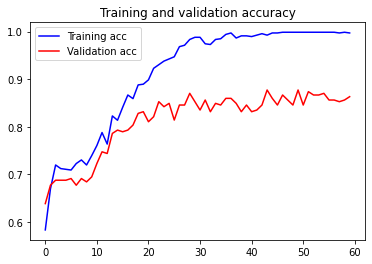

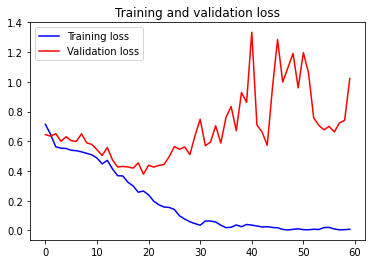

In [28]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
model_dropout = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(256*5*5, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=6400, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=1, bias=True)
  (16): Sigmoid()
)

In [31]:
epochs = 60
train_accuracies_dropout, train_losses_dropout, val_accuracies_dropout, val_losses_dropout = train_model(model_dropout, optimizer, loss_fn, train_loader, val_loader, epochs)

Streaming output truncated to the last 5000 lines.
[TRAIN] Epoch 41/60:  18%|█▊        | 2/11 [00:09<00:40,  4.52s/ batches, accuracy=0.523, loss=0.693]




[TRAIN] Epoch 41/60:  18%|█▊        | 2/11 [00:13<00:40,  4.52s/ batches, accuracy=0.495, loss=0.694]




[TRAIN] Epoch 41/60:  27%|██▋       | 3/11 [00:13<00:36,  4.51s/ batches, accuracy=0.495, loss=0.694]




[TRAIN] Epoch 41/60:  27%|██▋       | 3/11 [00:13<00:36,  4.51s/ batches, accuracy=0.495, loss=0.694]




[TRAIN] Epoch 41/60:  27%|██▋       | 3/11 [00:18<00:36,  4.51s/ batches, accuracy=0.508, loss=0.693]




[TRAIN] Epoch 41/60:  36%|███▋      | 4/11 [00:18<00:31,  4.53s/ batches, accuracy=0.508, loss=0.693]




[TRAIN] Epoch 41/60:  36%|███▋      | 4/11 [00:18<00:31,  4.53s/ batches, accuracy=0.508, loss=0.693]




[TRAIN] Epoch 41/60:  36%|███▋      | 4/11 [00:22<00:31,  4.53s/ batches, accuracy=0.522, loss=0.693]




[TRAIN] Epoch 41/60:  45%|████▌     | 5/11 [00:22<00:27,  4.53s/ batches, accuracy=0.522, loss=0.693]

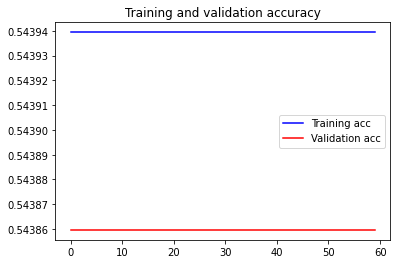

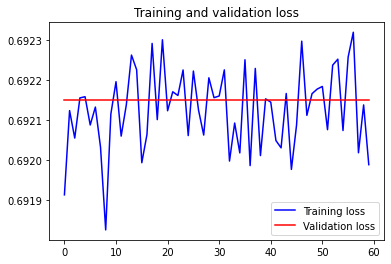

In [32]:
epochs = range(len(train_accuracies_dropout))

plt.plot(epochs, train_accuracies_dropout, 'b', label='Training acc')
plt.plot(epochs, val_accuracies_dropout, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses_dropout, 'b', label='Training loss')
plt.plot(epochs, val_losses_dropout, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = nn.BCELoss()
epochs = 30
train_accuracies_l2, train_losses_l2, val_accuracies_l2, val_losses_l2 = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

Streaming output truncated to the last 5000 lines.




[TRAIN] Epoch 14/30:  64%|██████▎   | 7/11 [00:31<00:17,  4.47s/ batches, accuracy=0.998, loss=0.00571]





[TRAIN] Epoch 14/30:  64%|██████▎   | 7/11 [00:35<00:17,  4.47s/ batches, accuracy=0.998, loss=0.0064] 





[TRAIN] Epoch 14/30:  73%|███████▎  | 8/11 [00:35<00:13,  4.46s/ batches, accuracy=0.998, loss=0.0064]





[TRAIN] Epoch 14/30:  73%|███████▎  | 8/11 [00:36<00:13,  4.46s/ batches, accuracy=0.998, loss=0.0064]





[TRAIN] Epoch 14/30:  73%|███████▎  | 8/11 [00:40<00:13,  4.46s/ batches, accuracy=0.998, loss=0.00613]





[TRAIN] Epoch 14/30:  82%|████████▏ | 9/11 [00:40<00:08,  4.47s/ batches, accuracy=0.998, loss=0.00613]





[TRAIN] Epoch 14/30:  82%|████████▏ | 9/11 [00:40<00:08,  4.47s/ batches, accuracy=0.998, loss=0.00613]





[TRAIN] Epoch 14/30:  82%|████████▏ | 9/11 [00:44<00:08,  4.47s/ batches, accuracy=0.997, loss=0.00964]





[TRAIN] Epoch 14/30:  91%|█████████ | 10/11 [00:44<00:04,  4.46s/ batches, 

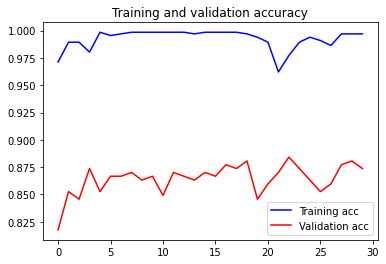

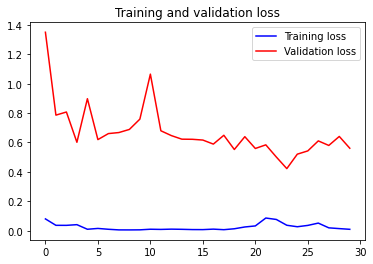

In [35]:
epochs = range(len(train_accuracies_l2))

plt.plot(epochs, train_accuracies_l2, 'b', label='Training acc')
plt.plot(epochs, val_accuracies_l2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses_l2, 'b', label='Training loss')
plt.plot(epochs, val_losses_l2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
torch.save(model, '/content/drive/My Drive/BitsXlaMarató/cough_detection_model_from_scratch.pt')
'''
To load it we can do:
model = torch.load(PATH)
model.eval()
'''